<a href="https://colab.research.google.com/github/sdharaskar/DS552/blob/main/DS552_S25_Assignment4_Swapnil_Dharaskar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Theory Qestions**


**Q1:** Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.  
**A1:**  
 The minimax loss function in GANs formalizes the adversarial game between the generator and the discriminator.
 $$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}\left[\log D(x)\right] + \mathbb{E}_{z \sim p_z(z)}\left[\log\left(1 - D\left(G(z)\right)\right)\right]
$$

The minimax loss function in GANs sets up an adversarial game where:
*   The discriminator maximizes its ability to correctly classify real and fake images.
*   The generator minimizes the loss by generating images that fool the discriminator.

This back-and-forth creates a competitive environment where both networks continuously improve, ideally converging to a point where the generated images are indistinguishable from real ones.




**Q2:** What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?  
**A2:**  Mode collapse occurs when a GAN’s generator produces a narrow range of outputs, failing to capture the diversity of the true data distribution. This issue can arise from the adversarial dynamics, instability in training, imbalances between the generator and discriminator, or issues with the loss function. Mitigation strategies include architectural changes like minibatch discrimination and feature matching, using alternative loss functions such as those in WGAN or LSGAN, regularization techniques, and even employing conditional GANs. These approaches help ensure that the generator learns to produce a variety of outputs, leading to more robust and stable GAN training.


**Q3:** Explain the role of the discriminator in adversarial training?  
**A3:**  
 In adversarial training—particularly in Generative Adversarial Networks (GANs)—the discriminator plays a central role as the “critic” or binary classifier that distinguishes between real data (from the true distribution) and fake data (produced by the generator).  
The discriminator in adversarial training:

* Differentiates between real and generated data,
* Drives the adversarial dynamics by providing a constantly evolving challenge for the generator,
* Supplies gradient feedback that guides both its own improvement and that of the generator, and
* Helps maintain training stability through various regularization techniques.  

This symbiotic relationship ensures that as the discriminator refines its classification ability, the generator is compelled to produce increasingly realistic data, which is the essence of adversarial training in GANs.

 **Q4:** How do metrics like IS and FID evaluate GAN performance?  
 **A4:**   


*   IS focuses on ensuring that each generated image is clear(low entropy $
p(y \mid x)$) and that the overall collection of images is diverse(high entropy $p(y)$). A higher Inception Score is considered better, but it doesn't directly measure how similar the generated distribution is to the real data distribution.
*   FID calculates the distance between the distributions of real and generated image features. A lower FID indicates that the generated images are both realistic and diverse, closely matching the statistics of the real data.  

Together, these metrics provide complementary insights into GAN performance, helping researchers and practitioners gauge the success of their models in generating high-quality and varied images.



# **2. Coding Assignment**

* Modify the generator to include additional convolutional layers.
* Implement image saving after every 10 epochs.
* Replace the MNIST dataset with CIFAR-10 and update the network for the new dimensions.


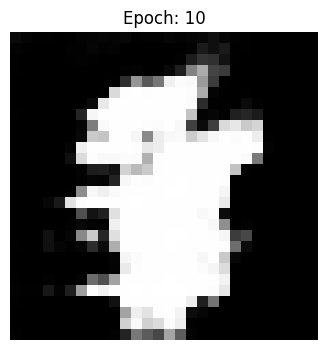

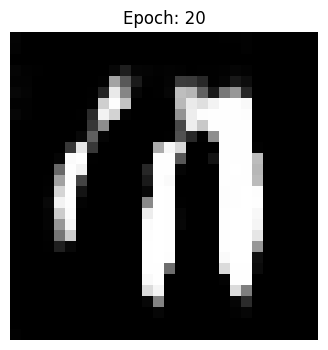

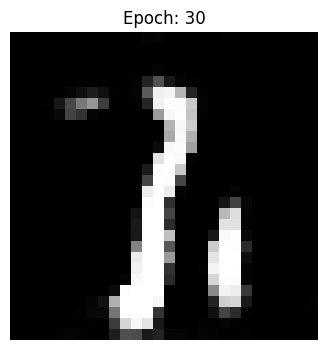

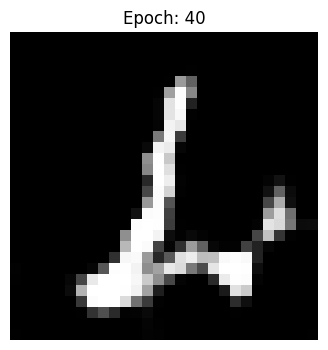

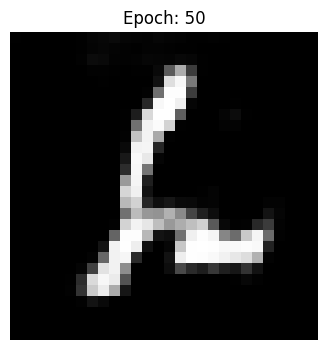

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -----------------------------
# Define the Generator Model
# -----------------------------
def make_generator_model():
    model = tf.keras.Sequential([
        # Project the noise vector into a 7x7x256 tensor.
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),

        # First transposed convolution block: keeps spatial dimensions at 7x7 while reducing depth.
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # --- Additional Convolutional Layers ---
        # These layers use a 3x3 kernel with 'same' padding to maintain spatial dimensions.
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second transposed convolution block: upsampling from 7x7 to 14x14.
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final transposed convolution block: upsampling from 14x14 to 28x28.
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# -----------------------------
# Define the Discriminator Model
# -----------------------------
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# -----------------------------
# Loss Functions and Optimizers
# -----------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# -----------------------------
# Training Step Function
# -----------------------------
@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# -----------------------------
# Function to Generate and Save One Image
# -----------------------------
def generate_and_save_image(model, epoch, test_input):
    predictions = model(test_input, training=False)
    image = predictions[0]  # Use the first image from the generated batch
    # Convert pixel values from [-1, 1] to [0, 255]
    image = ((image + 1) * 127.5).numpy().astype('uint8')

    plt.figure(figsize=(4, 4))
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("Epoch: {}".format(epoch))

    filename = 'image_at_epoch_{:04d}.png'.format(epoch)
    plt.savefig(filename)
    plt.show()
    plt.close()

# -----------------------------
# Training Loop (Processing 100 Batches per Epoch for debugging only)
# -----------------------------
def train(dataset, epochs):
    seed = tf.random.normal([1, 100])  # single image seed
    for epoch in range(epochs):
        # batch_count = 0
        for image_batch in dataset:
            train_step(image_batch)
            # batch_count += 1
            # if batch_count >= 100:  # Only process 100 batches per epoch
            #     break

        # Save and display the generated image every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_image(generator, epoch + 1, seed)

# -----------------------------
# Prepare the MNIST Dataset
# -----------------------------
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE)

# -----------------------------
# Run the Training Loop
# -----------------------------
train(train_dataset, epochs=50)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


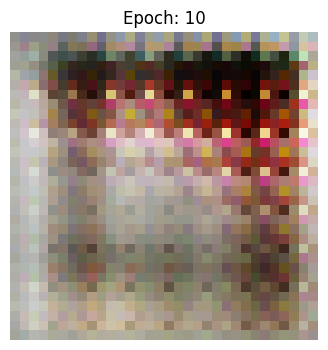

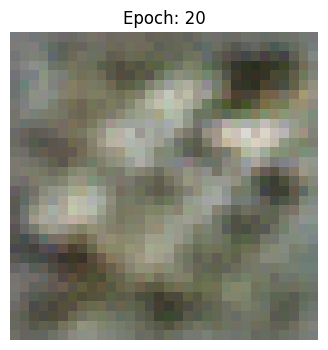

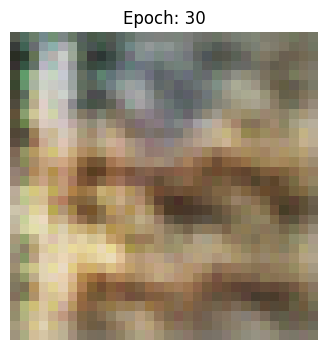

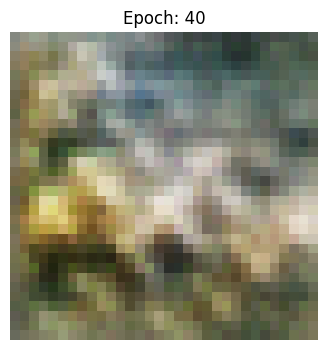

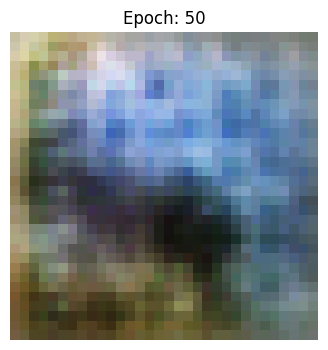

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -----------------------------
# Define the Generator Model for CIFAR-10
# -----------------------------
def make_generator_model():
    model = tf.keras.Sequential([
        # Project the noise vector into an 8x8x256 tensor.
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),

        # First transposed convolution block: keeps spatial dimensions at 8x8 while reducing depth.
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # --- Additional Convolutional Layers ---
        # These layers use a 3x3 kernel with 'same' padding to maintain spatial dimensions.
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second transposed convolution block: upsampling from 8x8 to 16x16.
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final transposed convolution block: upsampling from 16x16 to 32x32.
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# -----------------------------
# Define the Discriminator Model for CIFAR-10
# -----------------------------
def make_discriminator_model():
    model = tf.keras.Sequential([
        # Update the input shape to 32x32x3 for CIFAR-10 images.
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# -----------------------------
# Loss Functions and Optimizers
# -----------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# -----------------------------
# Training Step Function
# -----------------------------
BATCH_SIZE = 256

@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# -----------------------------
# Function to Generate and Save One Image
# -----------------------------
def generate_and_save_image(model, epoch, test_input):
    # Generate images from the test input and use only the first image.
    predictions = model(test_input, training=False)
    image = predictions[0]

    # Convert pixel values from [-1, 1] to [0, 255]
    image = ((image + 1) * 127.5).numpy().astype('uint8')

    plt.figure(figsize=(4, 4))
    plt.imshow(image)  # For RGB images, plt.imshow expects shape (32,32,3)
    plt.axis('off')
    plt.title("Epoch: {}".format(epoch))
    filename = 'image_at_epoch_{:04d}.png'.format(epoch)
    plt.savefig(filename)
    plt.show()
    plt.close()

# -----------------------------
# Training Loop
# -----------------------------
def train(dataset, epochs):
    # Fixed seed for generating images (so progress can be tracked)
    seed = tf.random.normal([1, 100])  # single image seed
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Save and display the generated image every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_image(generator, epoch + 1, seed)

# -----------------------------
# Prepare the CIFAR-10 Dataset
# -----------------------------
# Load CIFAR-10 data; CIFAR-10 has 50,000 training images and 10,000 test images.
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
# Normalize pixel values to [-1, 1]
train_images = (train_images - 127.5) / 127.5
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE)

# -----------------------------
# Run the Training Loop
# -----------------------------
train(train_dataset, epochs=50)
